# LendingClub Loan Data - Comprehensive Exploratory Data Analysis (EDA)

**Objective:**
- Perform a full EDA on the complete LendingClub dataset (2007–2018Q4)
- Inform feature engineering, data cleaning, class imbalance handling, and downstream model design

**Important:**
- Designed to be reproducible and extensible

## 1. Imports & Config

In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# !pip install missingno
import missingno as msno

from pathlib import Path

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)
sns.set_style("whitegrid")

## 2. Load Dataset

In [ ]:
DATA_PATH = Path("data/accepted_2007_to_2018Q4.csv")

print("Loading dataset...")
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Dataset loaded successfully.")

Loading dataset...
Dataset loaded successfully.


## 3. Dataset Overview

In [17]:
print("\n================ DATASET OVERVIEW ================\n")

print(f"Shape of dataset: {df.shape}")
print("\nMemory usage (MB):")
print(df.memory_usage(deep=True).sum() / 1024**2)

print("\nData Types:")
print(df.dtypes.value_counts())

# Why this matters:
# - Shape and memory help assess computational constraints
# - Data types guide preprocessing (numeric vs categorical vs datetime)


================ DATASET OVERVIEW ================

Shape of dataset: (2260701, 151)

Memory usage (MB):
5992.294716835022

Data Types:
float64    113
object      38
Name: count, dtype: int64


## 4. Missing Value Analysis

In [18]:
print("\n================ MISSING VALUE ANALYSIS ================\n")

missing_abs = df.isnull().sum()
missing_pct = (missing_abs / len(df)) * 100

missing_df = (
    pd.DataFrame({
        "missing_count": missing_abs,
        "missing_pct": missing_pct
    })
    .sort_values("missing_pct", ascending=False)
)

print("Top 20 features by missing percentage:")
print(missing_df.head(20))


================ MISSING VALUE ANALYSIS ================

Top 20 features by missing percentage:
                                            missing_count  missing_pct
member_id                                         2260701   100.000000
orig_projected_additional_accrued_interest        2252050    99.617331
hardship_reason                                   2249784    99.517097
hardship_payoff_balance_amount                    2249784    99.517097
hardship_last_payment_amount                      2249784    99.517097
payment_plan_start_date                           2249784    99.517097
hardship_type                                     2249784    99.517097
hardship_status                                   2249784    99.517097
hardship_start_date                               2249784    99.517097
deferral_term                                     2249784    99.517097
hardship_amount                                   2249784    99.517097
hardship_dpd                                      

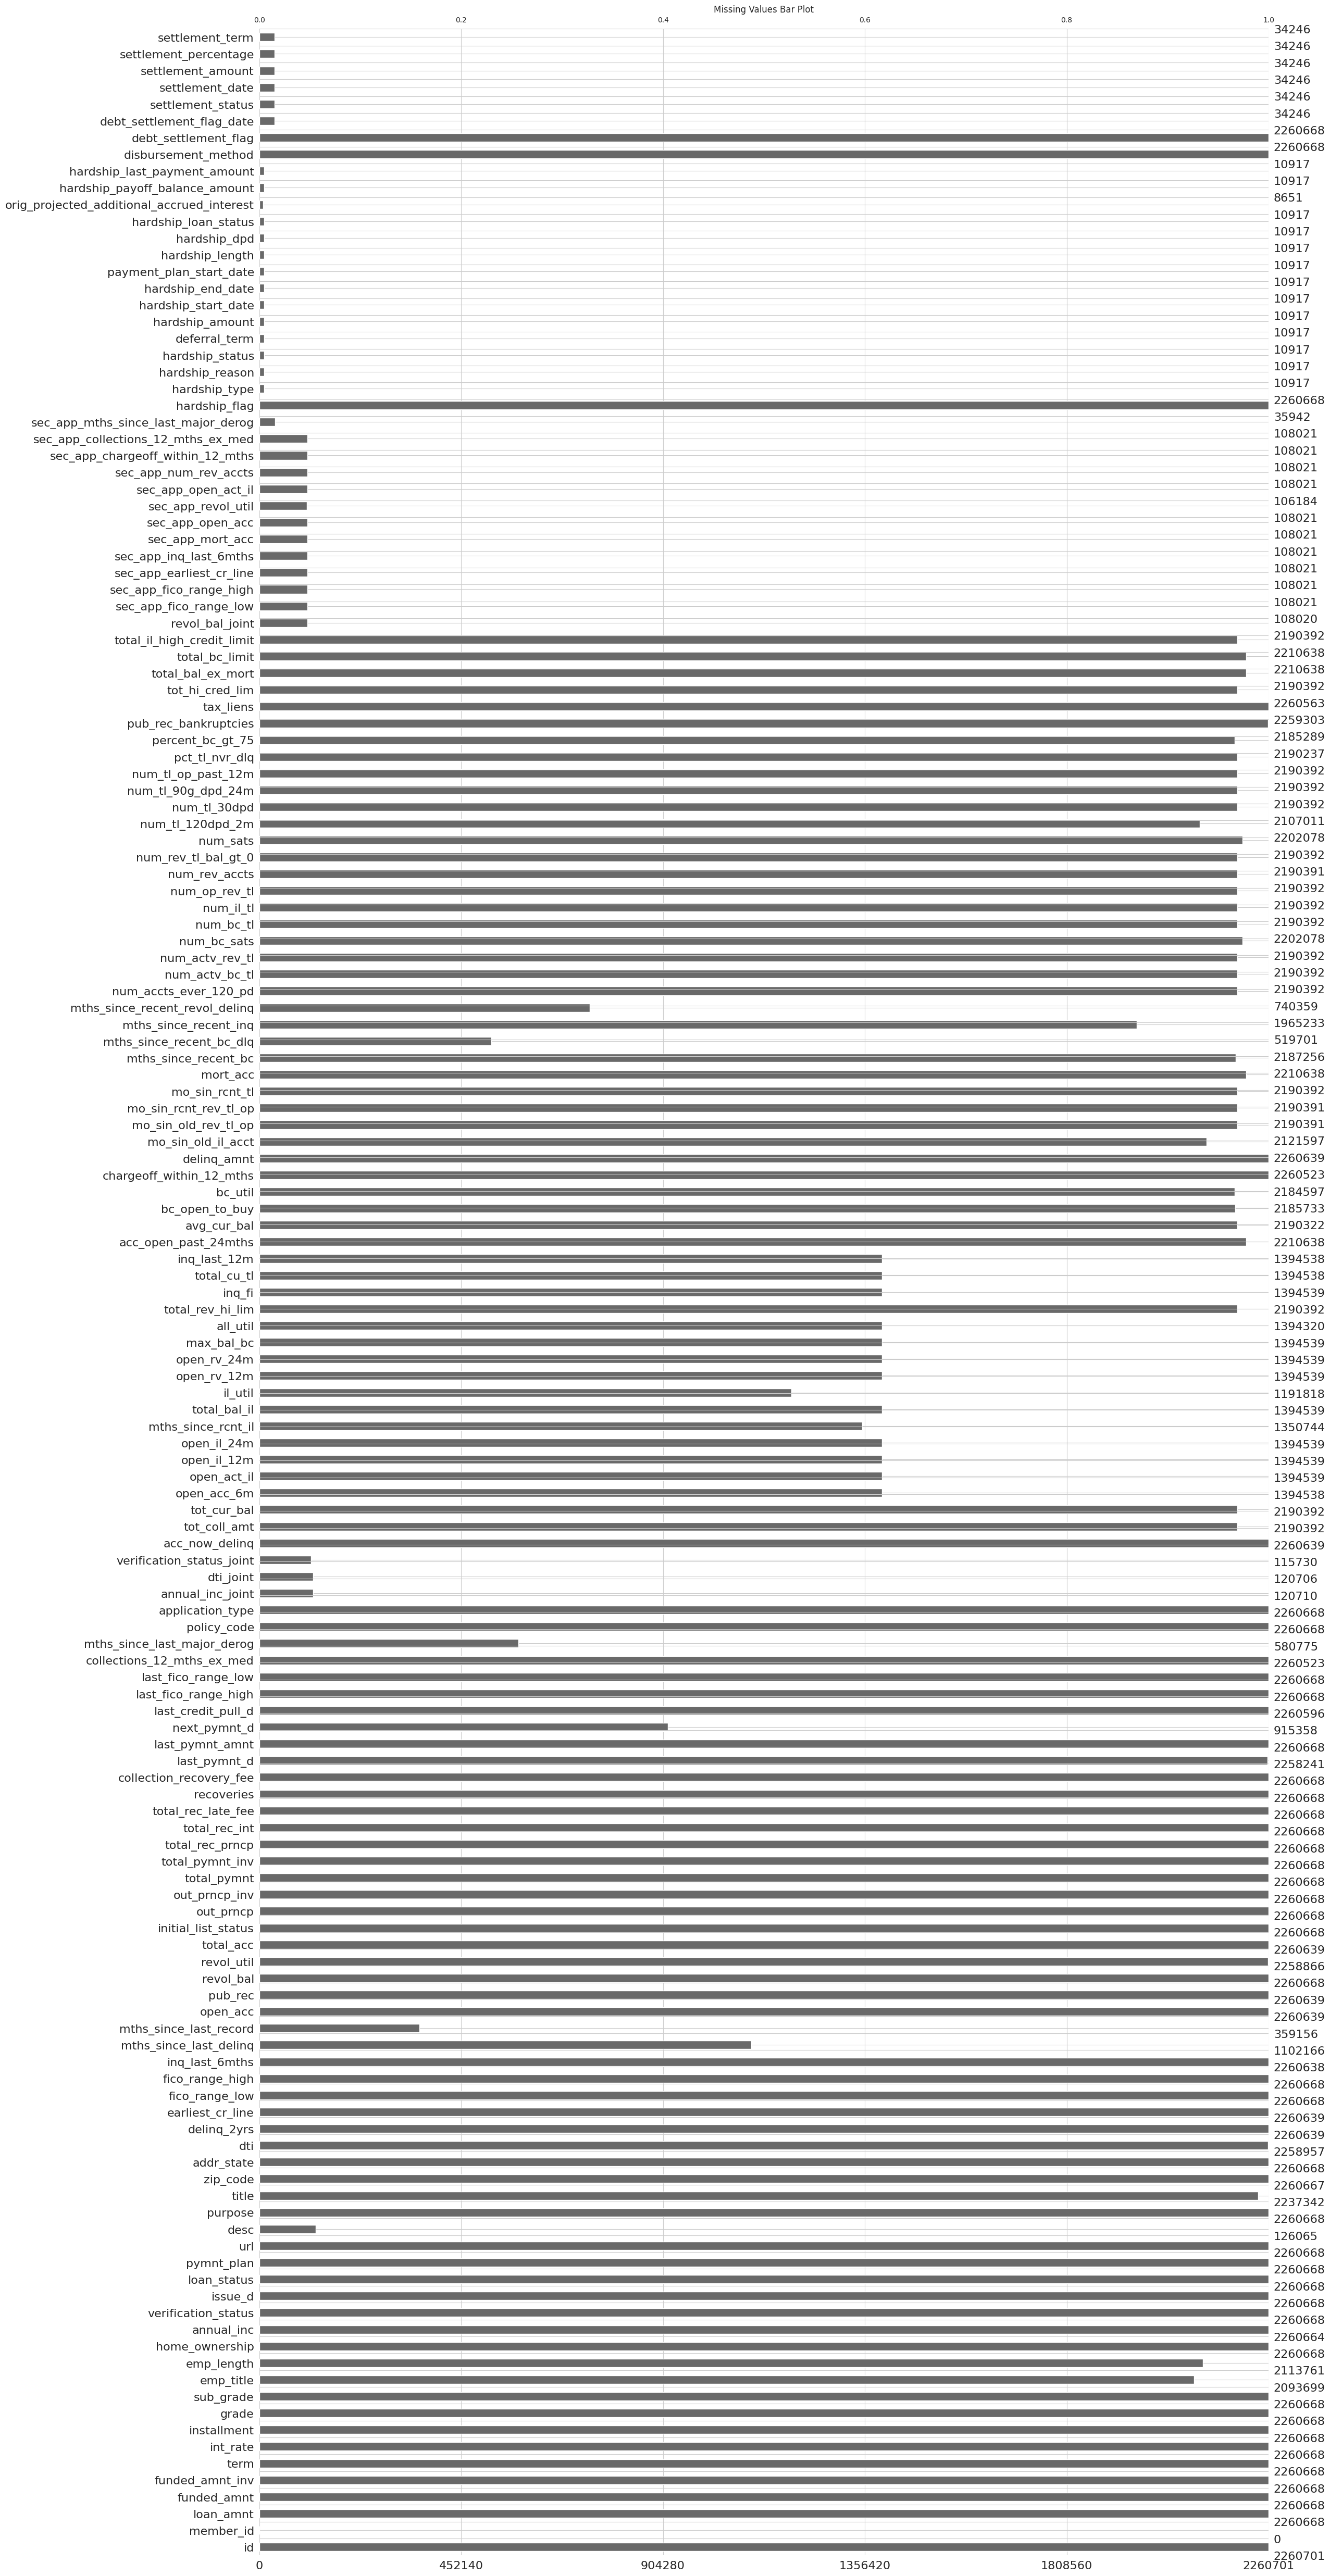

In [19]:
# Missing Values Bar Plot
msno.bar(df)
plt.title("Missing Values Bar Plot")
plt.show()

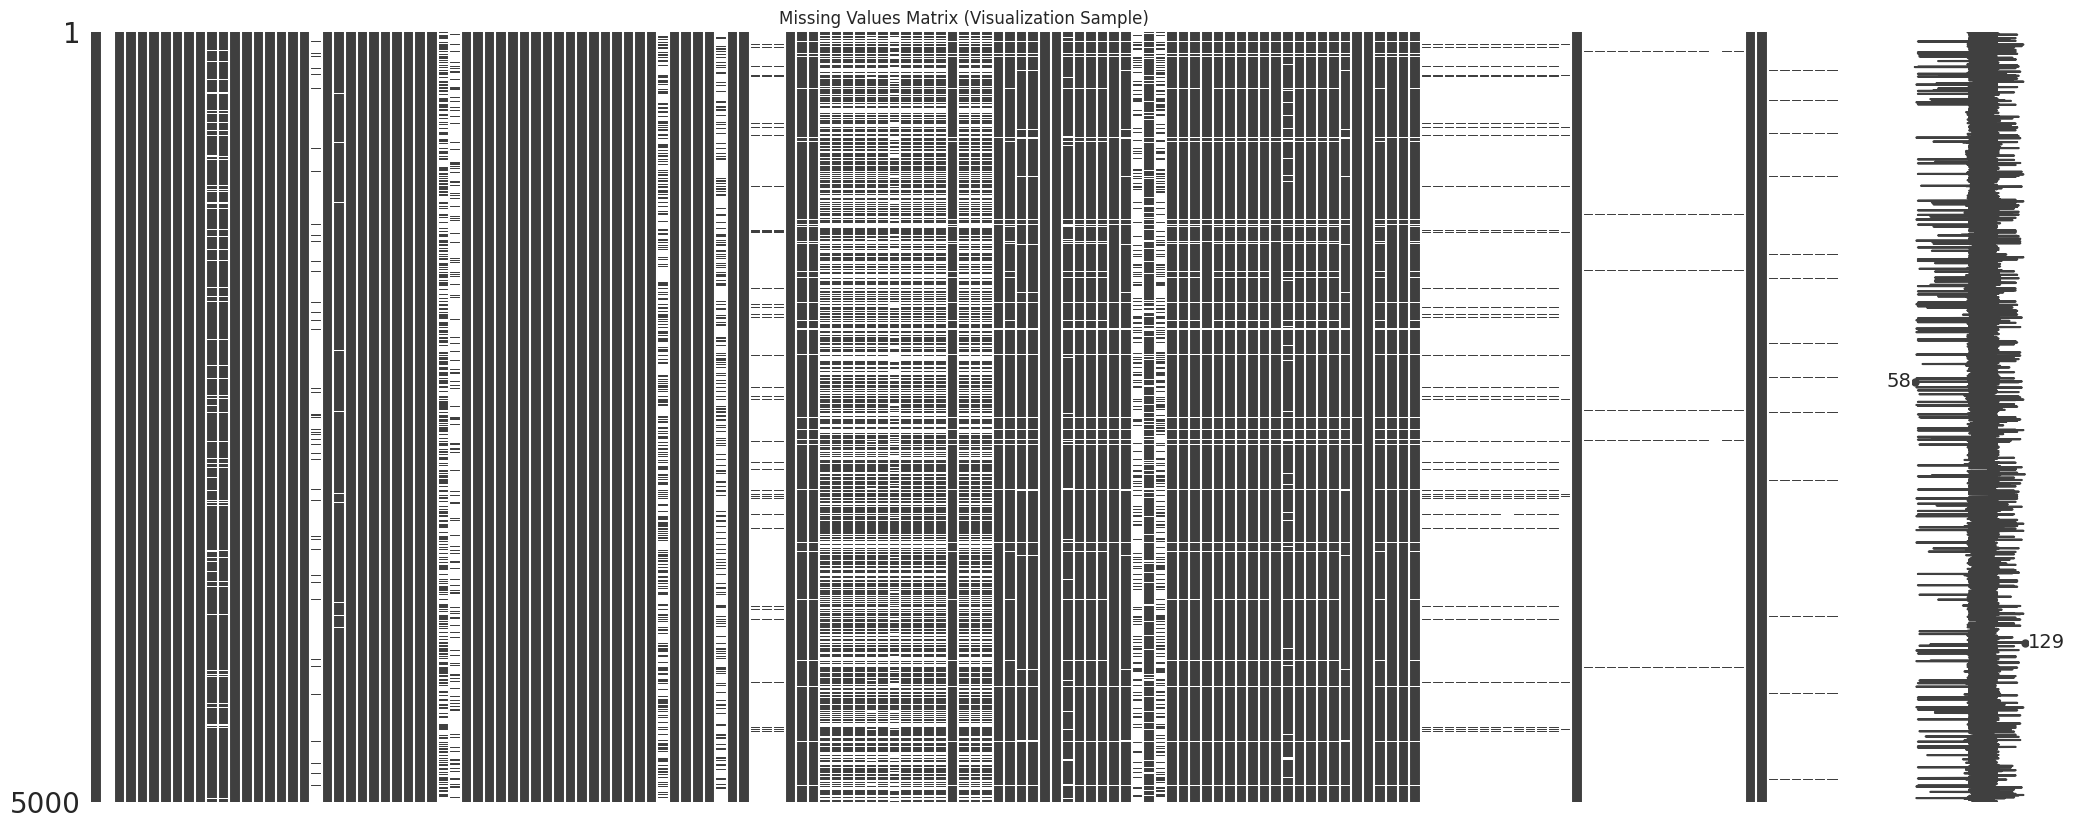

In [20]:
# Missing Values Matrix (sampled for visualization)
msno.matrix(df.sample(5000, random_state=42))
plt.title("Missing Values Matrix (Visualization Sample)")
plt.show()

In [21]:
# Identify highly missing features
HIGH_MISSING_THRESHOLD = 40.0  # %
high_missing_features = missing_df[missing_df["missing_pct"] > HIGH_MISSING_THRESHOLD]

print(f"\nFeatures with > {HIGH_MISSING_THRESHOLD}% missing values:")
print(high_missing_features.index.tolist())

# Why this matters:
# - High missingness may require dropping, imputation, or domain-driven decisions
# - Missing patterns may reveal structural data issues


Features with > 40.0% missing values:
['member_id', 'orig_projected_additional_accrued_interest', 'hardship_reason', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'payment_plan_start_date', 'hardship_type', 'hardship_status', 'hardship_start_date', 'deferral_term', 'hardship_amount', 'hardship_dpd', 'hardship_loan_status', 'hardship_length', 'hardship_end_date', 'settlement_status', 'debt_settlement_flag_date', 'settlement_term', 'settlement_percentage', 'settlement_date', 'settlement_amount', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'revol_bal_joint', 'sec_app_inq_last_6mths', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_mort_acc', 'sec_app_open_act_il', 'sec_app_fico_range_low', 'sec_app_collections_12_mths_ex_med', 'sec_app_chargeoff_within_12_mths', 'verification_status_joint', 'dti_joint', 'annual_inc_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_s

## 5. Target Variable Analysis


================ TARGET VARIABLE ANALYSIS ================

Loan Status Distribution:
loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64


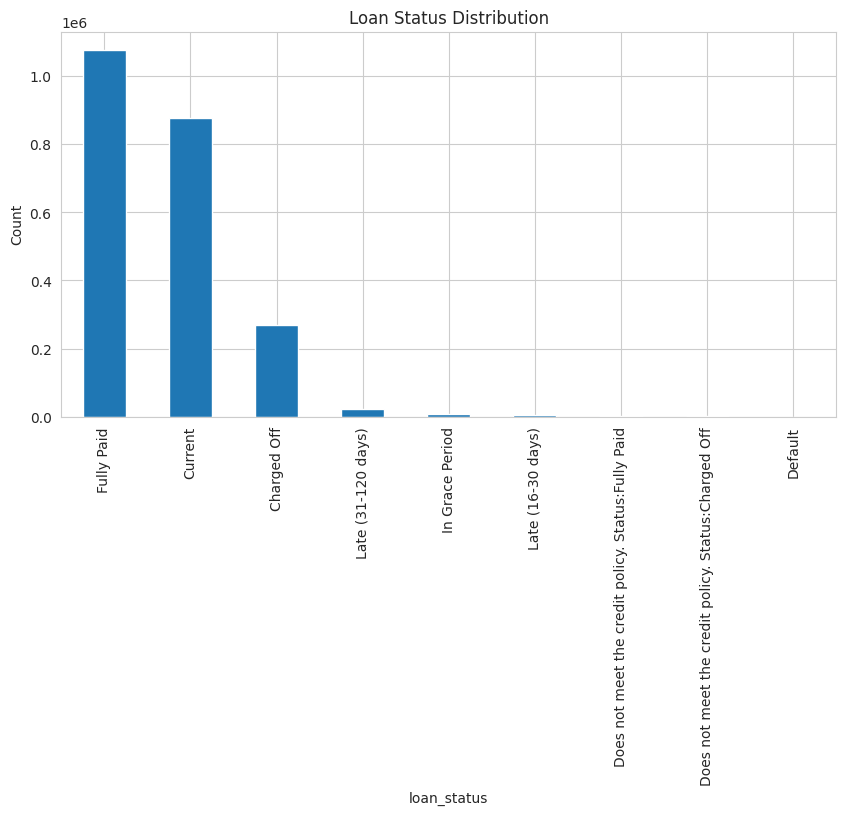

In [22]:
print("\n================ TARGET VARIABLE ANALYSIS ================\n")

print("Loan Status Distribution:")
loan_status_counts = df["loan_status"].value_counts()
print(loan_status_counts)

plt.figure(figsize=(10, 5))
loan_status_counts.plot(kind="bar")
plt.title("Loan Status Distribution")
plt.ylabel("Count")
plt.show()

In [23]:
# Mapping loan_status into binary target
good_status = ["Fully Paid", "Current"]
bad_status = ["Charged Off", "Default", "Late (31-120 days)", "Late (16-30 days)"]

df["target_default"] = np.where(
    df["loan_status"].isin(bad_status), 1,
    np.where(df["loan_status"].isin(good_status), 0, np.nan)
)

print("\nBinary Target Distribution (Default vs Non-Default):")
print(df["target_default"].value_counts(dropna=False))

# Calculate and display imbalance ratio
default_rate = df["target_default"].mean() * 100
print(f"\nDefault Rate: {default_rate:.2f}%")

# Why this matters:
# - LendingClub has severe class imbalance
# - Proper target mapping is critical before modeling
# - NaN targets indicate ambiguous or transitional loan states


Binary Target Distribution (Default vs Non-Default):
target_default
0.0    1955068
1.0     294415
NaN      11218
Name: count, dtype: int64

Default Rate: 13.09%


## 6. Numerical Feature Analysis

In [24]:
print("\n================ NUMERICAL FEATURE ANALYSIS ================\n")

# Dynamically select numeric features, excluding IDs and leakage columns
exclude_cols = {
    # Identifiers - no predictive value
    "id", "member_id",
    # Potential leakage (post-loan features)
    "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt",
    # Target variable
    "target_default"
}

all_numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in all_numeric_cols if col not in exclude_cols]

print(f"Total numeric features (excluding IDs/leakage): {len(numerical_features)}")
print(f"All numeric features: {numerical_features}")


================ NUMERICAL FEATURE ANALYSIS ================

Total numeric features (excluding IDs/leakage): 105
All numeric features: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'de

Analyzing top 10 features by variance: ['tot_hi_cred_lim', 'tot_cur_bal', 'annual_inc', 'annual_inc_joint', 'total_bal_ex_mort', 'total_il_high_credit_limit', 'total_bal_il', 'total_rev_hi_lim', 'revol_bal_joint', 'total_bc_limit']


Analyzing: tot_hi_cred_lim
count    2.190392e+06
mean     1.782428e+05
std      1.815748e+05
min      0.000000e+00
25%      5.073100e+04
50%      1.142985e+05
75%      2.577550e+05
max      9.999999e+06
Name: tot_hi_cred_lim, dtype: float64


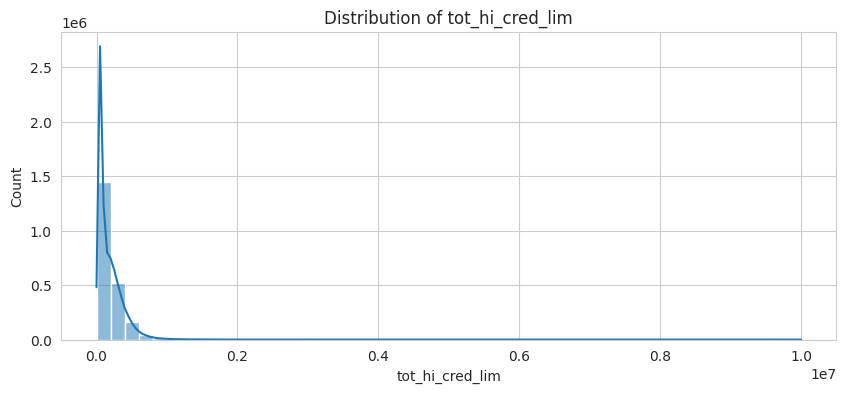

Skewness of tot_hi_cred_lim: 3.83

Analyzing: tot_cur_bal
count    2.190392e+06
mean     1.424922e+05
std      1.606926e+05
min      0.000000e+00
25%      2.909200e+04
50%      7.924000e+04
75%      2.132040e+05
max      9.971659e+06
Name: tot_cur_bal, dtype: float64


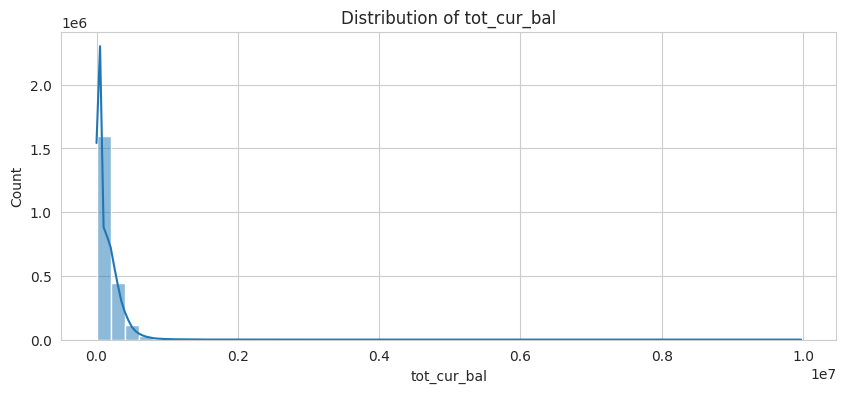

Skewness of tot_cur_bal: 2.97

Analyzing: annual_inc
count    2.260664e+06
mean     7.799243e+04
std      1.126962e+05
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.300000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64


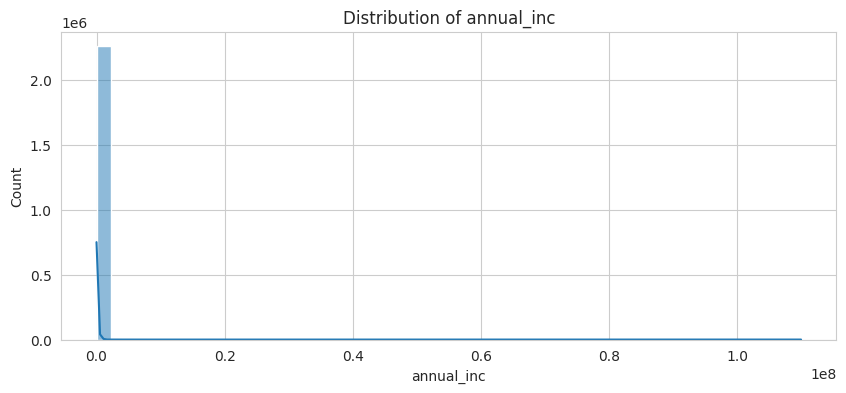

Skewness of annual_inc: 493.89

Analyzing: annual_inc_joint
count    1.207100e+05
mean     1.236246e+05
std      7.416135e+04
min      5.693510e+03
25%      8.340000e+04
50%      1.100000e+05
75%      1.479950e+05
max      7.874821e+06
Name: annual_inc_joint, dtype: float64


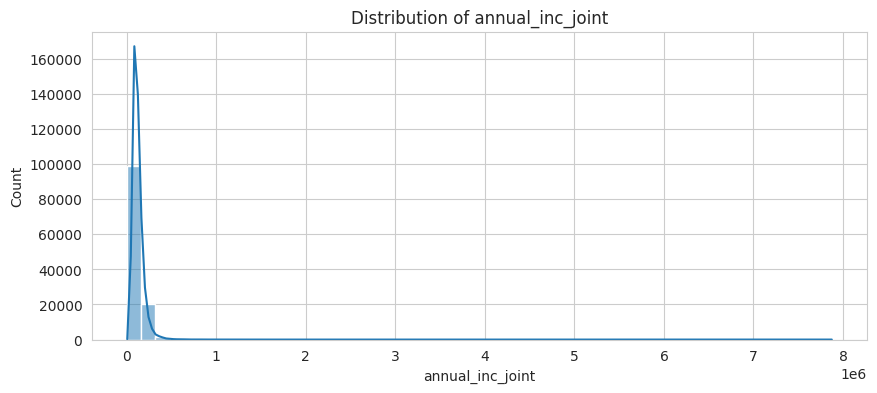

Skewness of annual_inc_joint: 21.74

Analyzing: total_bal_ex_mort
count    2.210638e+06
mean     5.102294e+04
std      4.991124e+04
min      0.000000e+00
25%      2.089200e+04
50%      3.786400e+04
75%      6.435000e+04
max      3.408095e+06
Name: total_bal_ex_mort, dtype: float64


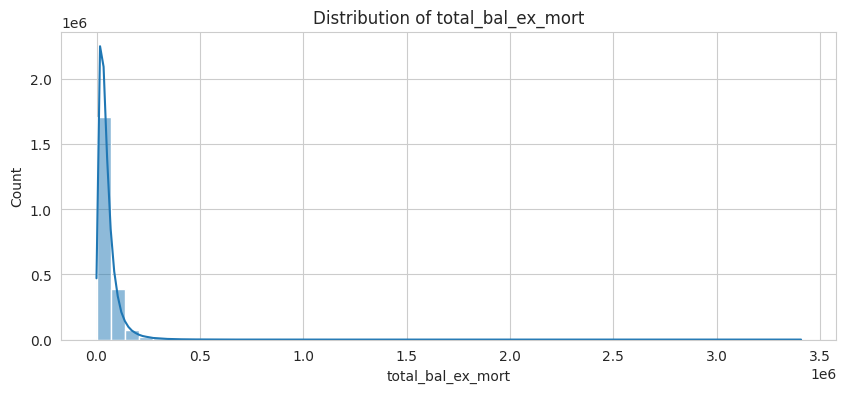

Skewness of total_bal_ex_mort: 4.24

Analyzing: total_il_high_credit_limit
count    2.190392e+06
mean     4.373201e+04
std      4.507298e+04
min      0.000000e+00
25%      1.500000e+04
50%      3.269600e+04
75%      5.880425e+04
max      2.118996e+06
Name: total_il_high_credit_limit, dtype: float64


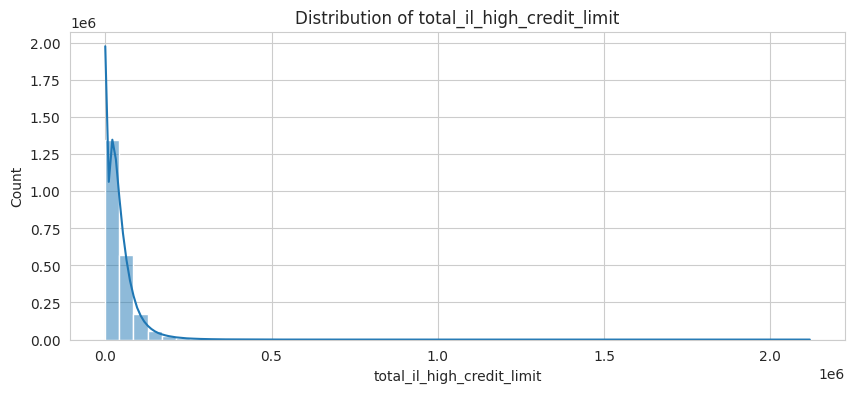

Skewness of total_il_high_credit_limit: 3.10

Analyzing: total_bal_il
count    1.394539e+06
mean     3.550665e+04
std      4.409746e+04
min      0.000000e+00
25%      8.695000e+03
50%      2.312700e+04
75%      4.609500e+04
max      1.837038e+06
Name: total_bal_il, dtype: float64


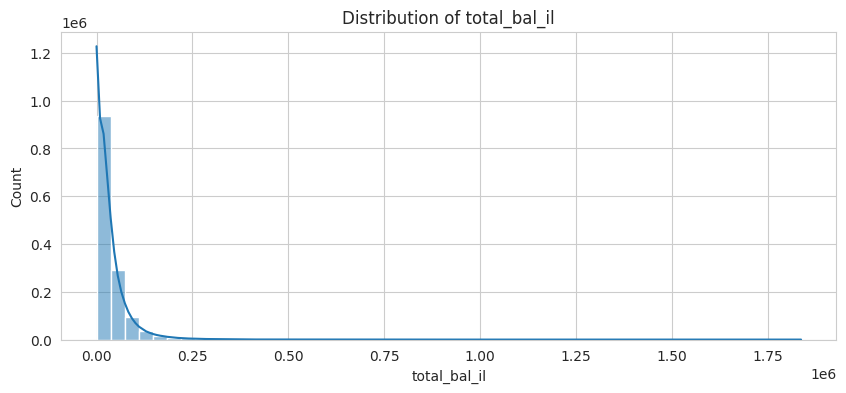

Skewness of total_bal_il: 3.82

Analyzing: total_rev_hi_lim
count    2.190392e+06
mean     3.457394e+04
std      3.672850e+04
min      0.000000e+00
25%      1.470000e+04
50%      2.540000e+04
75%      4.320000e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64


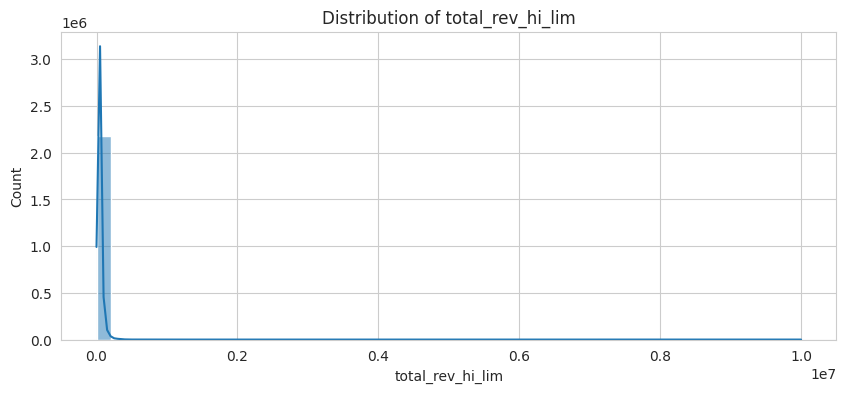

Skewness of total_rev_hi_lim: 32.56

Analyzing: revol_bal_joint
count    1.080200e+05
mean     3.361728e+04
std      2.815387e+04
min      0.000000e+00
25%      1.510675e+04
50%      2.651650e+04
75%      4.376900e+04
max      1.110019e+06
Name: revol_bal_joint, dtype: float64


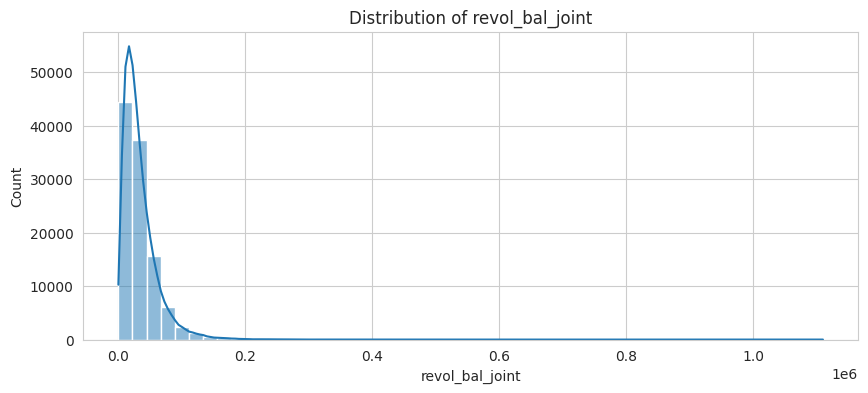

Skewness of revol_bal_joint: 3.02

Analyzing: total_bc_limit
count    2.210638e+06
mean     2.319377e+04
std      2.300656e+04
min      0.000000e+00
25%      8.300000e+03
50%      1.630000e+04
75%      3.030000e+04
max      1.569000e+06
Name: total_bc_limit, dtype: float64


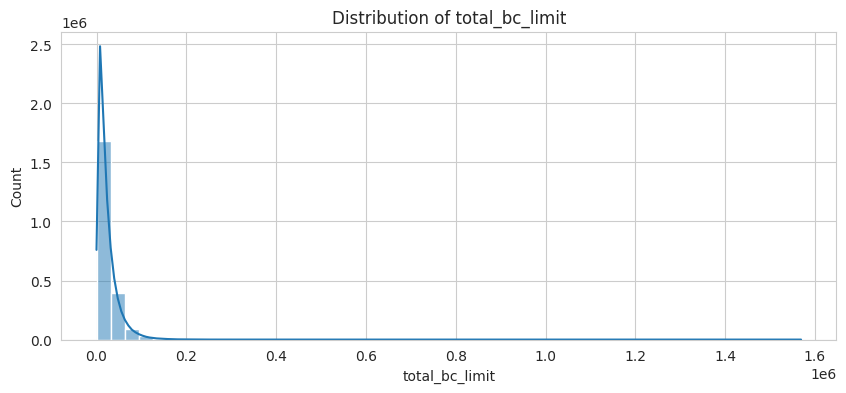

Skewness of total_bc_limit: 2.99


In [25]:
# Analyze top features by variance (most informative for EDA)
variances = df[numerical_features].var().sort_values(ascending=False)
top_features_to_plot = variances.head(10).index.tolist()

print(f"Analyzing top 10 features by variance: {top_features_to_plot}\n")

for col in top_features_to_plot:
    print(f"\nAnalyzing: {col}")
    print(df[col].describe())

    plt.figure(figsize=(10, 4))
    sns.histplot(df[col].dropna(), bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

    # Skewness
    skew = df[col].skew()
    print(f"Skewness of {col}: {skew:.2f}")

# Why this matters:
# - Financial variables are typically right-skewed
# - May require log transforms or robust scaling
# - Outliers can distort model training

In [26]:
# Summary statistics for ALL numeric features
print("\nSummary statistics for all numeric features:")
numeric_summary = df[numerical_features].describe().T
numeric_summary["skewness"] = df[numerical_features].skew()
numeric_summary["missing_pct"] = (df[numerical_features].isnull().sum() / len(df)) * 100
print(numeric_summary.sort_values("skewness", ascending=False).head(20))


Summary statistics for all numeric features:
                                        count           mean            std           min       25%        50%        75%           max    skewness  missing_pct
tot_coll_amt                        2190392.0     232.731739    8518.461819  0.000000e+00      0.00       0.00       0.00  9.152545e+06  852.010132     3.110053
annual_inc                          2260664.0   77992.428687  112696.199574  0.000000e+00  46000.00   65000.00   93000.00  1.100000e+08  493.886088     0.001637
delinq_amnt                         2260639.0      12.369828     726.464781  0.000000e+00      0.00       0.00       0.00  2.499250e+05  102.654774     0.002743
num_tl_120dpd_2m                    2107011.0       0.000637       0.027106  0.000000e+00      0.00       0.00       0.00  7.000000e+00   55.809847     6.798334
total_rev_hi_lim                    2190392.0   34573.942769   36728.495448  0.000000e+00  14700.00   25400.00   43200.00  9.999999e+06   32.557427  

## 7. Outlier Analysis


================ OUTLIER ANALYSIS ================



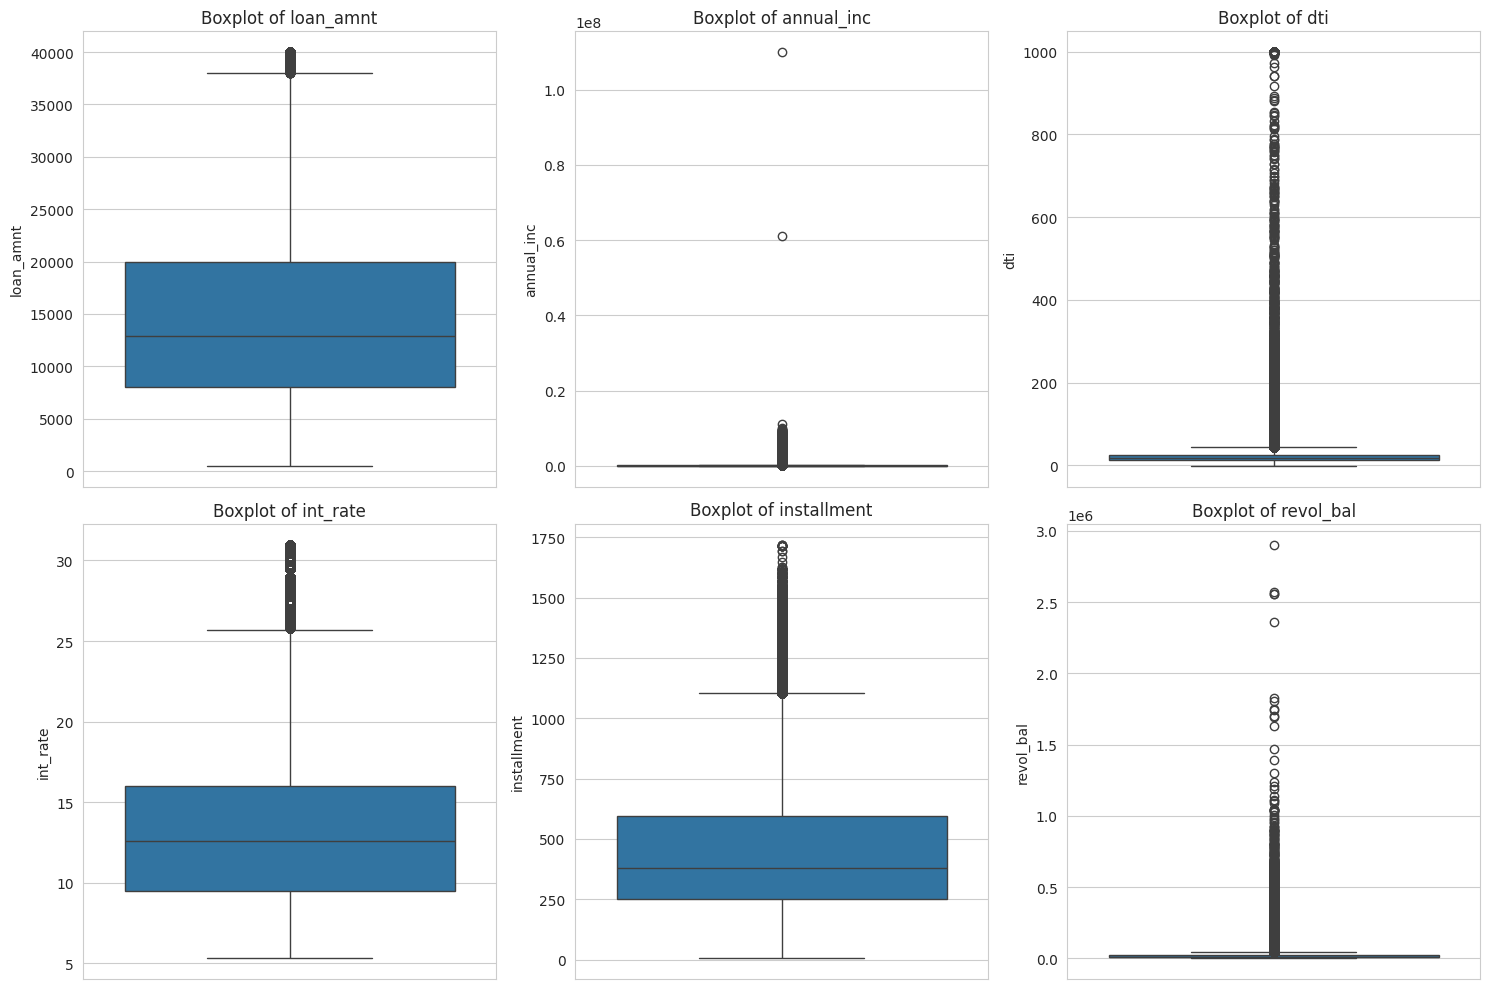

In [27]:
print("\n================ OUTLIER ANALYSIS ================\n")

# Key financial features for outlier analysis
key_features = ["loan_amnt", "annual_inc", "dti", "int_rate", "installment", "revol_bal"]
key_features = [f for f in key_features if f in df.columns]

# Boxplots for key features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(key_features):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

In [28]:
# IQR-based outlier detection summary
def count_outliers_iqr(series):
    """Count outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((series < lower_bound) | (series > upper_bound)).sum()
    return outliers, outliers / len(series) * 100

print("Outlier Summary (IQR Method):")
print("-" * 50)

outlier_summary = []
for col in numerical_features[:20]:  # Top 20 features
    count, pct = count_outliers_iqr(df[col].dropna())
    outlier_summary.append({"feature": col, "outlier_count": count, "outlier_pct": pct})

outlier_df = pd.DataFrame(outlier_summary).sort_values("outlier_pct", ascending=False)
print(outlier_df.head(15))

# Why this matters:
# - Income often has extreme outliers (millionaires in dataset)
# - Outliers can heavily influence linear models
# - Consider log transforms, capping, or robust scalers

Outlier Summary (IQR Method):
--------------------------------------------------
            feature  outlier_count  outlier_pct
7       delinq_2yrs         421531    18.646542
14          pub_rec         357881    15.830966
19    out_prncp_inv         212305     9.391251
18        out_prncp         212242     9.388464
15        revol_bal         137095     6.064358
5        annual_inc         110041     4.867641
10   inq_last_6mths          94314     4.172008
13         open_acc          84754     3.749117
8    fico_range_low          74846     3.310791
9   fico_range_high          74846     3.310791
4       installment          66312     2.933292
3          int_rate          41099     1.818002
17        total_acc          39411     1.743357
0         loan_amnt          35215     1.557725
1       funded_amnt          35215     1.557725


## 8. Bivariate Analysis (Features vs Target)


================ BIVARIATE ANALYSIS ================



/tmp/ipython-input-3321714003.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(["Non-Default", "Default"])
/tmp/ipython-input-3321714003.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(["Non-Default", "Default"])
/tmp/ipython-input-3321714003.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(["Non-Default", "Default"])
/tmp/ipython-input-3321714003.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(["Non-Default", "Default"])
/tmp/ipython-input-3321714003.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. af

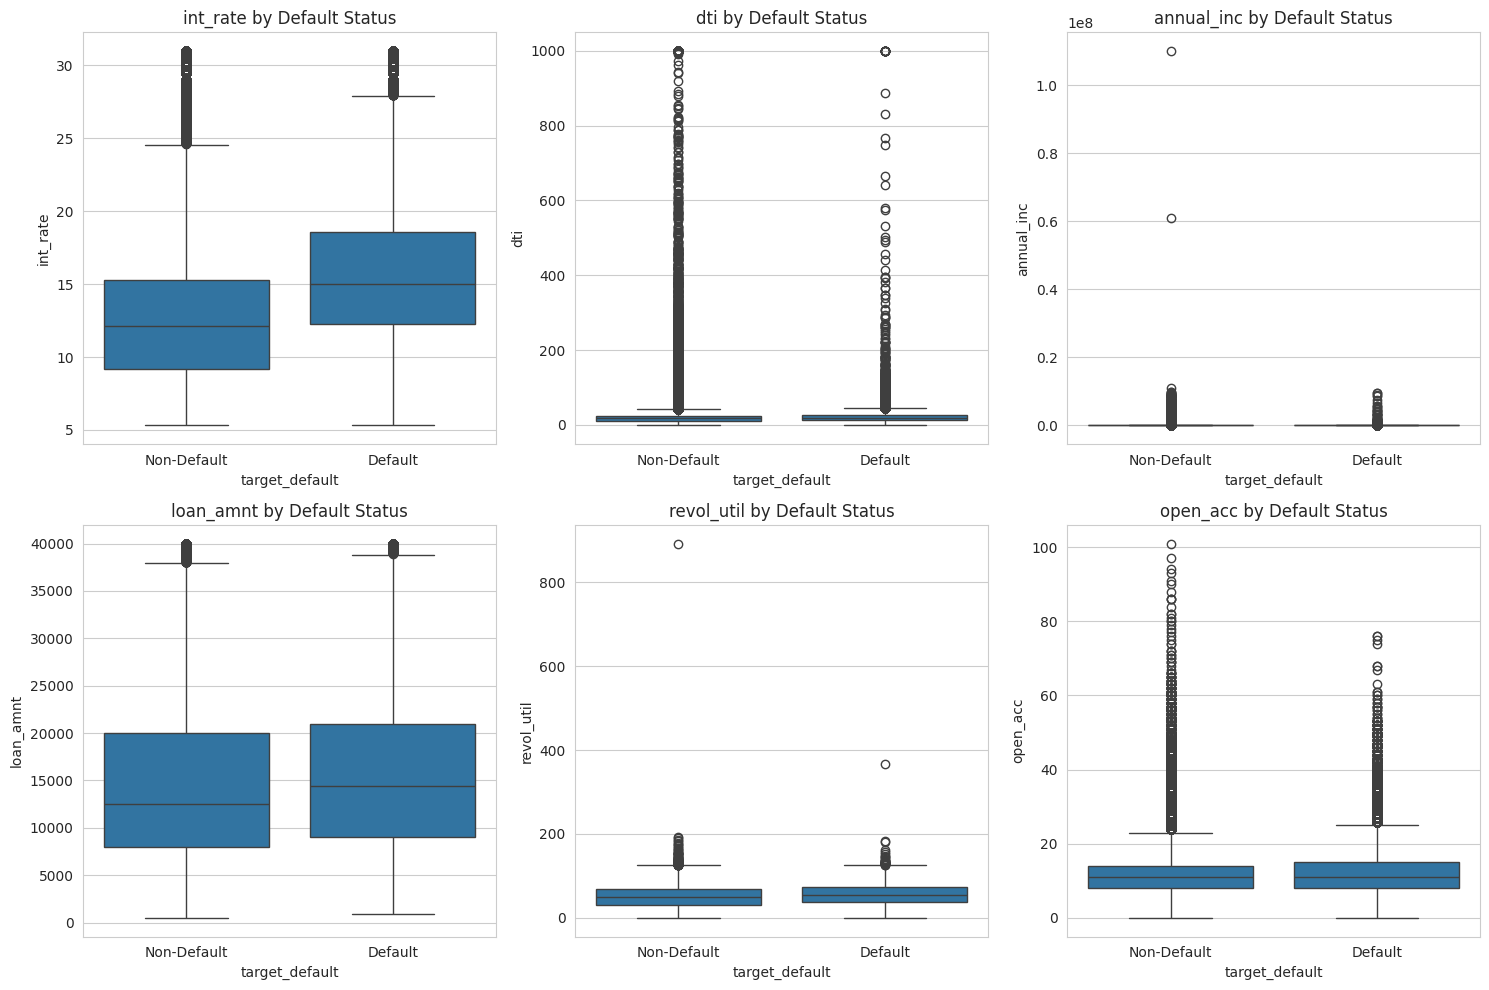

In [29]:
print("\n================ BIVARIATE ANALYSIS ================\n")

# Filter to rows with valid target
df_valid = df[df["target_default"].notna()].copy()
df_valid["target_default"] = df_valid["target_default"].astype(int)

# Key numeric features vs target
bivariate_features = ["int_rate", "dti", "annual_inc", "loan_amnt", "revol_util", "open_acc"]
bivariate_features = [f for f in bivariate_features if f in df_valid.columns]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(bivariate_features):
    sns.boxplot(data=df_valid, x="target_default", y=col, ax=axes[i])
    axes[i].set_title(f"{col} by Default Status")
    axes[i].set_xticklabels(["Non-Default", "Default"])

plt.tight_layout()
plt.show()

In [30]:
# Correlation with target
print("\nFeature Correlation with Target (Default):")
print("-" * 50)

target_corr = df_valid[numerical_features + ["target_default"]].corr()["target_default"].drop("target_default")
target_corr_sorted = target_corr.abs().sort_values(ascending=False)

print("\nTop 15 features most correlated with default:")
for feat in target_corr_sorted.head(15).index:
    corr_val = target_corr[feat]
    direction = "↑" if corr_val > 0 else "↓"
    print(f"  {feat}: {corr_val:.4f} {direction}")

# Why this matters:
# - Higher int_rate typically correlates with higher default risk
# - These correlations inform feature selection for modeling


Feature Correlation with Target (Default):
--------------------------------------------------

Top 15 features most correlated with default:
  last_fico_range_high: -0.6149 ↓
  last_fico_range_low: -0.5625 ↓
  hardship_dpd: 0.2405 ↑
  int_rate: 0.2104 ↑
  out_prncp: -0.1690 ↓
  out_prncp_inv: -0.1690 ↓
  total_rec_late_fee: 0.1397 ↑
  sec_app_fico_range_low: -0.1319 ↓
  sec_app_fico_range_high: -0.1319 ↓
  fico_range_low: -0.1219 ↓
  fico_range_high: -0.1219 ↓
  sec_app_inq_last_6mths: 0.0992 ↑
  hardship_amount: 0.0959 ↑
  acc_open_past_24mths: 0.0958 ↑
  inq_last_6mths: 0.0855 ↑



Default Rate by Categorical Features:
--------------------------------------------------

grade:
grade
G    40.726078
F    36.939946
E    28.747468
D    20.755110
C    14.647658
B     8.822827
A     3.670856
Name: target_default, dtype: float64

home_ownership:
home_ownership
OTHER       18.750000
RENT        15.211111
NONE        14.285714
OWN         13.140648
MORTGAGE    11.371676
ANY          7.575758
Name: target_default, dtype: float64

purpose:
purpose
small_business        20.436581
educational           17.125382
renewable_energy      16.585704
moving                15.917113
debt_consolidation    14.155919
medical               13.658322
other                 13.218872
house                 12.949897
vacation              12.444243
major_purchase        12.267124
wedding               12.135711
home_improvement      11.538230
credit_card           10.645896
car                    9.910363
Name: target_default, dtype: float64

term:
term
60 months    17.947267
36 months    11

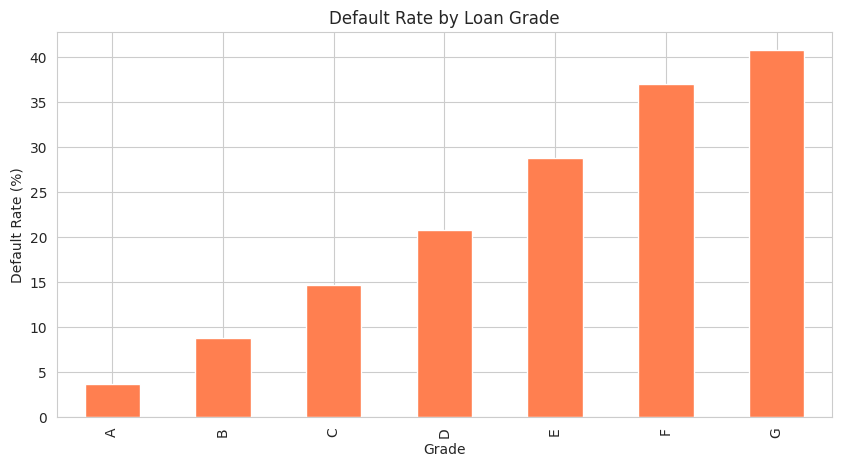

In [31]:
# Categorical features vs target
cat_features = ["grade", "home_ownership", "purpose", "term"]
cat_features = [f for f in cat_features if f in df_valid.columns]

print("\nDefault Rate by Categorical Features:")
print("-" * 50)

for col in cat_features:
    default_rate_by_cat = df_valid.groupby(col)["target_default"].mean() * 100
    print(f"\n{col}:")
    print(default_rate_by_cat.sort_values(ascending=False))

# Visualization for grade (important risk indicator)
if "grade" in df_valid.columns:
    plt.figure(figsize=(10, 5))
    grade_default = df_valid.groupby("grade")["target_default"].mean() * 100
    grade_default.sort_index().plot(kind="bar", color="coral")
    plt.title("Default Rate by Loan Grade")
    plt.ylabel("Default Rate (%)")
    plt.xlabel("Grade")
    plt.show()

## 9. Temporal Features Analysis

In [32]:
print("\n================ TEMPORAL FEATURES ANALYSIS ================\n")

# Parse date features
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d"]
date_cols = [c for c in date_cols if c in df.columns]

print(f"Date columns found: {date_cols}")

# Parse issue_d (loan issue date)
if "issue_d" in df.columns:
    df["issue_date"] = pd.to_datetime(df["issue_d"], format="%b-%Y", errors="coerce")
    df["issue_year"] = df["issue_date"].dt.year
    df["issue_month"] = df["issue_date"].dt.month
    print(f"\nIssue date range: {df['issue_date'].min()} to {df['issue_date'].max()}")

# Parse earliest_cr_line (credit history start)
if "earliest_cr_line" in df.columns:
    df["earliest_cr_date"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%Y", errors="coerce")
    # Calculate credit history length in years
    df["credit_history_years"] = (df["issue_date"] - df["earliest_cr_date"]).dt.days / 365.25
    print(f"Credit history range: {df['credit_history_years'].min():.1f} to {df['credit_history_years'].max():.1f} years")


================ TEMPORAL FEATURES ANALYSIS ================

Date columns found: ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']

Issue date range: 2007-06-01 00:00:00 to 2018-12-01 00:00:00
Credit history range: 0.5 to 83.3 years


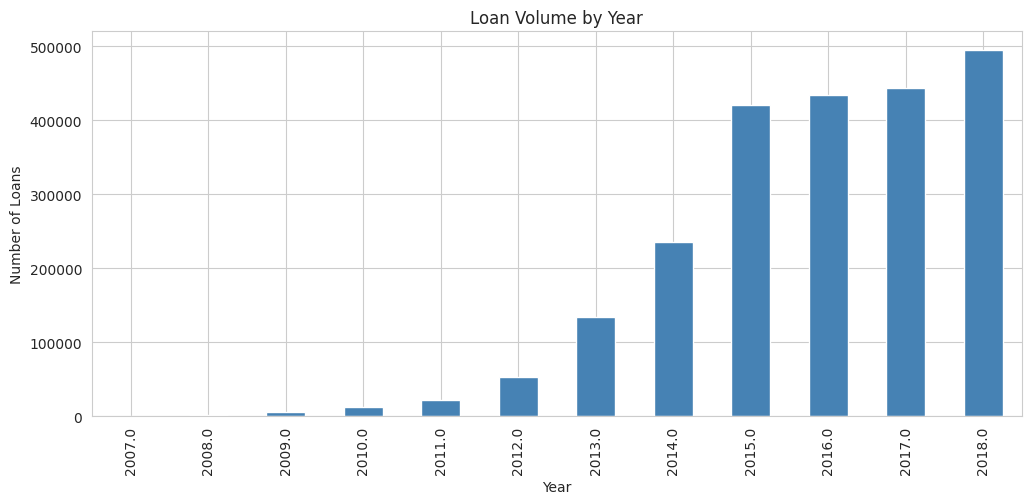


Loan volume by year:
issue_year
2007.0       603
2008.0      2393
2009.0      5281
2010.0     12537
2011.0     21721
2012.0     53367
2013.0    134814
2014.0    235629
2015.0    421095
2016.0    434407
2017.0    443579
2018.0    495242
dtype: int64


In [33]:
# Loan volume over time
if "issue_year" in df.columns:
    plt.figure(figsize=(12, 5))

    yearly_volume = df.groupby("issue_year").size()
    yearly_volume.plot(kind="bar", color="steelblue")
    plt.title("Loan Volume by Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Loans")
    plt.show()

    print("\nLoan volume by year:")
    print(yearly_volume)

In [34]:
# Default rate trend over years
if "issue_year" in df_valid.columns:
    plt.figure(figsize=(12, 5))

    yearly_default = df_valid.groupby("issue_year")["target_default"].mean() * 100
    yearly_default.plot(kind="line", marker="o", color="coral", linewidth=2)
    plt.title("Default Rate Trend Over Years")
    plt.xlabel("Year")
    plt.ylabel("Default Rate (%)")
    plt.grid(True, alpha=0.3)
    plt.show()

    print("\nDefault rate by year:")
    print(yearly_default)

# Why this matters:
# - Economic cycles affect default rates (2008 financial crisis visible)
# - Recent loans may have lower observed defaults due to incomplete maturity

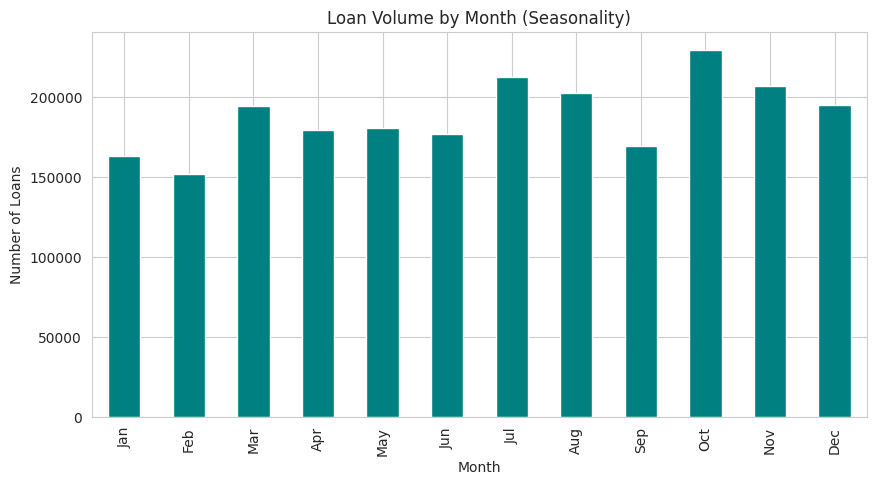

In [35]:
# Monthly seasonality
if "issue_month" in df.columns:
    plt.figure(figsize=(10, 5))

    monthly_volume = df.groupby("issue_month").size()
    monthly_volume.plot(kind="bar", color="teal")
    plt.title("Loan Volume by Month (Seasonality)")
    plt.xlabel("Month")
    plt.ylabel("Number of Loans")
    plt.xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    plt.show()

In [36]:
# Credit history length vs default
if "credit_history_years" in df_valid.columns:
    plt.figure(figsize=(10, 5))

    # Cap extreme values for visualization
    df_valid["credit_history_capped"] = df_valid["credit_history_years"].clip(0, 50)

    sns.boxplot(data=df_valid, x="target_default", y="credit_history_capped")
    plt.title("Credit History Length by Default Status")
    plt.xlabel("Default Status")
    plt.ylabel("Credit History (Years)")
    plt.xticks([0, 1], ["Non-Default", "Default"])
    plt.show()

    print("\nCredit history stats by default status:")
    print(df_valid.groupby("target_default")["credit_history_years"].describe())

## 10. Categorical Feature Analysis

In [37]:
print("\n================ CATEGORICAL FEATURE ANALYSIS ================\n")

categorical_cols = df.select_dtypes(include=["object"]).columns

cardinality = df[categorical_cols].nunique().sort_values(ascending=False)

print("Top 20 categorical features by cardinality:")
print(cardinality.head(20))


================ CATEGORICAL FEATURE ANALYSIS ================

Top 20 categorical features by cardinality:
id                           2260701
url                          2260668
emp_title                     512694
desc                          124500
title                          63154
zip_code                         956
earliest_cr_line                 754
sec_app_earliest_cr_line         663
last_credit_pull_d               141
issue_d                          139
last_pymnt_d                     136
next_pymnt_d                     106
settlement_date                   90
debt_settlement_flag_date         83
addr_state                        51
sub_grade                         35
hardship_end_date                 28
hardship_start_date               27
payment_plan_start_date           27
purpose                           14
dtype: int64


In [38]:
HIGH_CARDINALITY_THRESHOLD = 100

high_cardinality_features = cardinality[cardinality > HIGH_CARDINALITY_THRESHOLD]

print("\nHigh-cardinality categorical features:")
print(high_cardinality_features)


High-cardinality categorical features:
id                          2260701
url                         2260668
emp_title                    512694
desc                         124500
title                         63154
zip_code                        956
earliest_cr_line                754
sec_app_earliest_cr_line        663
last_credit_pull_d              141
issue_d                         139
last_pymnt_d                    136
next_pymnt_d                    106
dtype: int64


In [39]:
# Dominant category analysis
print("\nDominant category analysis (top 10 categorical features):")
for col in categorical_cols[:10]:
    top_category_pct = df[col].value_counts(normalize=True).iloc[0] * 100
    print(f"{col}: top category covers {top_category_pct:.2f}%")

# Why this matters:
# - High-cardinality features may require encoding strategies or exclusion
# - Dominant categories reduce information gain


Dominant category analysis (top 10 categorical features):
id: top category covers 0.00%
term: top category covers 71.21%
grade: top category covers 29.35%
sub_grade: top category covers 6.45%
emp_title: top category covers 1.85%
emp_length: top category covers 35.39%
home_ownership: top category covers 49.16%
verification_status: top category covers 39.20%
issue_d: top category covers 2.74%
loan_status: top category covers 47.63%


## 11. Correlation Analysis


================ CORRELATION ANALYSIS ================



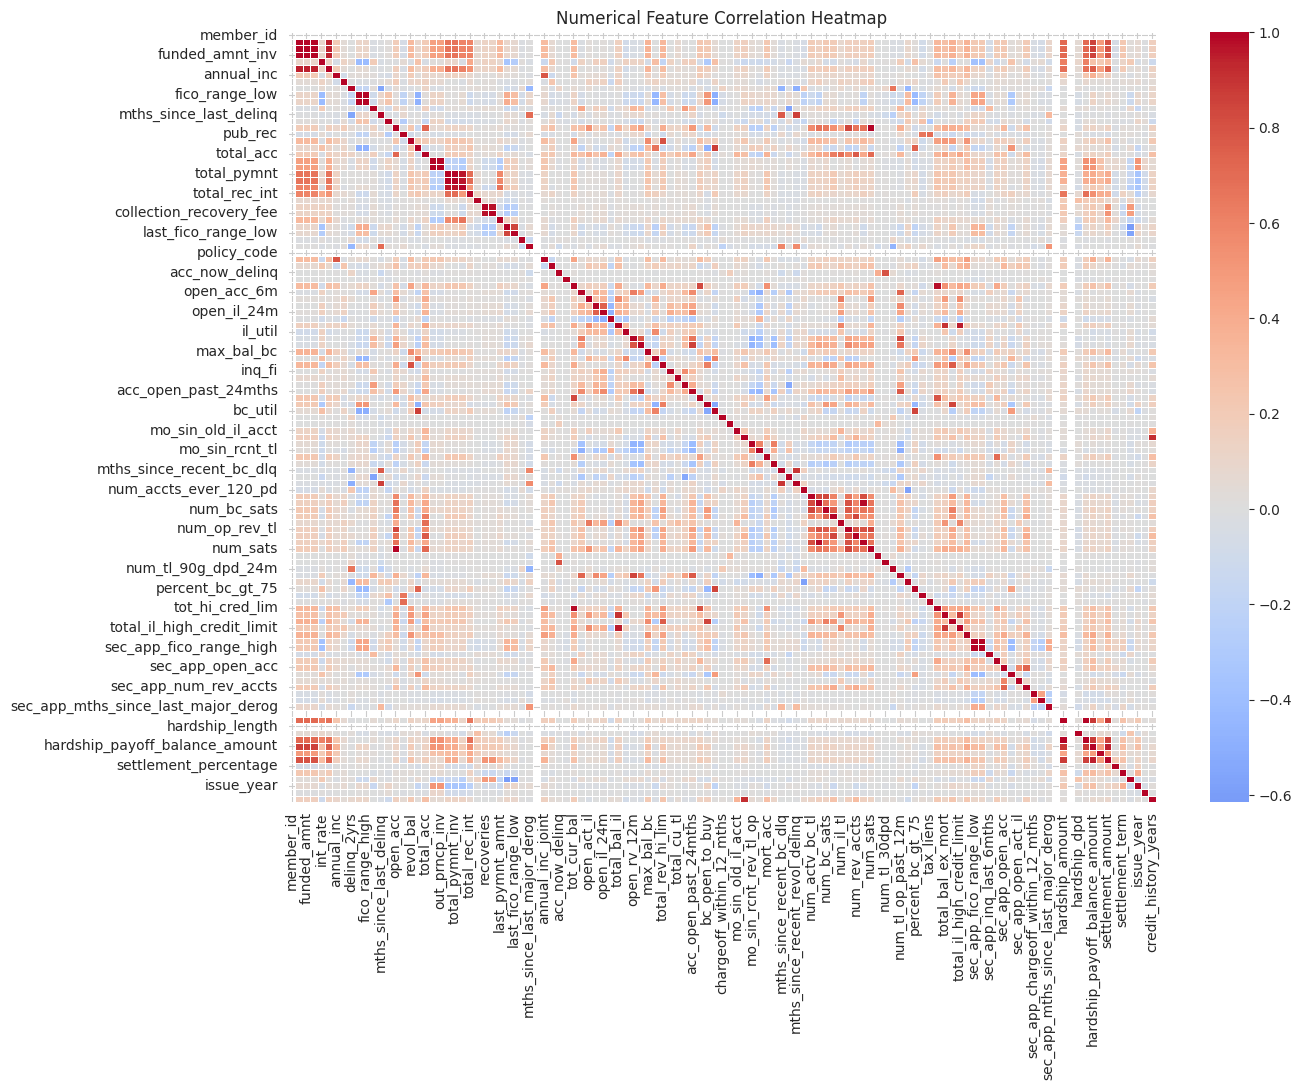

In [40]:
print("\n================ CORRELATION ANALYSIS ================\n")

numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Numerical Feature Correlation Heatmap")
plt.show()

In [41]:
# Identify highly correlated feature pairs
CORR_THRESHOLD = 0.8

high_corr_pairs = (
    corr_matrix.abs()
    .unstack()
    .sort_values(ascending=False)
)

high_corr_pairs = high_corr_pairs[
    (high_corr_pairs < 1.0) & (high_corr_pairs > CORR_THRESHOLD)
]

print("Highly correlated feature pairs (> 0.8):")
print(high_corr_pairs.head(20))

# Why this matters:
# - Multicollinearity can destabilize linear models
# - Feature pruning or regularization may be required

Highly correlated feature pairs (> 0.8):
sec_app_fico_range_high  sec_app_fico_range_low     1.000000
sec_app_fico_range_low   sec_app_fico_range_high    1.000000
fico_range_high          fico_range_low             1.000000
fico_range_low           fico_range_high            1.000000
out_prncp                out_prncp_inv              0.999999
out_prncp_inv            out_prncp                  0.999999
loan_amnt                funded_amnt                0.999755
funded_amnt              loan_amnt                  0.999755
total_pymnt_inv          total_pymnt                0.999396
total_pymnt              total_pymnt_inv            0.999396
funded_amnt              funded_amnt_inv            0.999341
funded_amnt_inv          funded_amnt                0.999341
loan_amnt                funded_amnt_inv            0.999038
funded_amnt_inv          loan_amnt                  0.999038
open_acc                 num_sats                   0.998966
num_sats                 open_acc           

## 12. Data Leakage & Modeling Risks

In [42]:
print("\n================ DATA LEAKAGE & MODELING CONSIDERATIONS ================\n")

potential_leakage_features = [
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_prncp",
    "total_rec_int",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_amnt",
    "last_pymnt_d",
    "next_pymnt_d"
]

print("Potential data leakage / post-loan features:")
for feat in potential_leakage_features:
    if feat in df.columns:
        print(f"- {feat}")


================ DATA LEAKAGE & MODELING CONSIDERATIONS ================

Potential data leakage / post-loan features:
- total_pymnt
- total_pymnt_inv
- total_rec_prncp
- total_rec_int
- recoveries
- collection_recovery_fee
- last_pymnt_amnt
- last_pymnt_d
- next_pymnt_d


In [43]:
id_features = ["id", "member_id", "url"]

print("\nIdentifier features (not useful for modeling):")
for feat in id_features:
    if feat in df.columns:
        print(f"- {feat}")

# Why this matters:
# - Leakage leads to unrealistically high model performance
# - Only features available at loan application time should be used


Identifier features (not useful for modeling):
- id
- member_id
- url


## 13. Summary & Next Steps

In [44]:
print("\n================ SUMMARY & NEXT STEPS ================\n")

print("""
Key Takeaways:
- Dataset is large, sparse, and highly imbalanced
- Significant missingness in several features
- Strong skewness and outliers in financial variables (especially annual_inc)
- High-cardinality categorical features require careful handling
- Multiple post-loan features must be excluded to prevent leakage
- Clear relationship between loan grade/interest rate and default risk
- Temporal trends show impact of economic cycles on default rates
- Longer credit history correlates with lower default risk

Next Steps:
- Feature selection based on application-time availability
- Missing value imputation strategy
- Log/robust transformations for skewed variables
- Outlier treatment (capping, winsorization)
- Class imbalance handling (SMOTE, undersampling, cost-sensitive learning)
- Feature engineering from temporal variables (credit history length)
- Model development (tree-based, linear, deep learning, or offline RL)
""")


================ SUMMARY & NEXT STEPS ================


Key Takeaways:
- Dataset is large, sparse, and highly imbalanced
- Significant missingness in several features
- Strong skewness and outliers in financial variables (especially annual_inc)
- High-cardinality categorical features require careful handling
- Multiple post-loan features must be excluded to prevent leakage
- Clear relationship between loan grade/interest rate and default risk
- Temporal trends show impact of economic cycles on default rates
- Longer credit history correlates with lower default risk

Next Steps:
- Feature selection based on application-time availability
- Missing value imputation strategy
- Log/robust transformations for skewed variables
- Outlier treatment (capping, winsorization)
- Class imbalance handling (SMOTE, undersampling, cost-sensitive learning)
- Feature engineering from temporal variables (credit history length)
- Model development (tree-based, linear, deep learning, or offline RL)

